# Otimização da distribuição temporal de empregados em regime híbrido

O objetivo desse projeto é otimizar, através da utilização de algoritmos genéticos, a distribuição dos dias de trabalho presencial dos colaboradores de uma mesma empresa buscando:

1. Atingir o nível de ocupação do espaço desejado por dia da semana;
2. Garantir a alocação de gerências relacionadas nos mesmos dias de trabalho.

A lógica construída permite acomodar as seguintes restrições:

1. A capacidade física do espaço;
2. Ocupação desejada diferente por dia da semana;
3. Quantidade de dias presenciais exigidos diferente por gerência;
4. Fixação dos dias de trabalho presencial de determinadas gerências;
5. Seleção de combinações de dias não-permitidas;
6. Definição por pesos de qual critério de avaliação do objetivo é mais relevante (ocupação ou relacionamento entre gerências).

In [41]:
! pip install deap matplotlib ipywidgets ipympl adjustText


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
import pandas as pd
import numpy as np
import random

from itertools import permutations

from deap import base
from deap import creator
from deap import tools
from deap import algorithms

from adjustText import adjust_text

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [43]:
%matplotlib widget

### Leitura dos arquivos .csv de input

O projeto depende de dois arquivos .csv de input

- `pessoas_por_gerencia.csv`: esse arquivo deve possuir os IDs de cada gerência, a sua quantidade de pessoas e a quantidade de dias obrigatórios.
- `relacionamentos.csv`: esse arquivo deve possuir, para cada gerência, a lista de IDs das gerências relacionadas, ou seja, aquelas que preferencialmente devem estar nos mesmos dias de presencial.

In [44]:
# Lendo arquivos de input para obter quantidade de pessoas por gerência
df_pessoas_por_gerencia = pd.read_csv(
    'pessoas_por_gerencia.csv',
    sep=';',
    dtype={'ID': int, 'ID GG': int, 'Gerência': str, 'Classificação': str, 'Quantidade': int, 'Dias obrigatórios': int}
).fillna(0)

df_relacionamentos = pd.read_csv('relacionamentos.csv', sep=";")

### Constantes

In [45]:
QTD_DIAS_SEMANA = 5
COLUNAS_DIAS = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta']
COLUNA_QTD = 'Quantidade' # Coluna do arquivo pessoas_por_gerencia com a quantidade

# Definindo constantes a partir dos arquivos lidos

QUANTIDADE_EMPREGADOS = df_pessoas_por_gerencia[COLUNA_QTD].sum()
COUNT_GERENCIAS = df_pessoas_por_gerencia['ID'].count()
MIN_ID_GERENCIA, MAX_ID_GERENCIA = df_pessoas_por_gerencia['ID'].min(), df_pessoas_por_gerencia['ID'].max()
DIAS_PRESENCIAIS_POR_GERENCIA = df_pessoas_por_gerencia['Dias obrigatórios'].to_list()

RELACIONAMENTOS = df_relacionamentos.set_index('ID').to_dict()['Relacionamentos']
RELACIONAMENTOS = {k: [int(n) for n in RELACIONAMENTOS[k].split(',')] for k in RELACIONAMENTOS.keys()}

### Inputs do usuário

In [46]:
# Capacidade máxima de pessoas
CAPACIDADE_PREDIO = 290

# Lista de inteiros que representam com a quantidade de dias da semana possíveis
# para distribuição.
QTD_DIAS_PRESENCIAIS_POSSIVEIS = [2, 3]

# Lista de combinações de dias proibidas. Cada combinação é uma lista de 5 booleanos
# representados por 0 ou 1, indicando se o dia da semana correspondente àquela posição 
# é permitido (1) ou não (0).
COMBINACOES_DIAS_PROIBIDAS = [
    # Combinações com dois dias de presencial
    [0,1,1,0,0], # obrigatório ter pelo menos segunda ou sexta
    [0,0,1,1,0], # obrigatório ter pelo menos segunda ou sexta
    [0,1,0,1,0], # obrigatório ter pelo menos segunda ou sexta
    [1,0,0,0,1], # proibir segunda e sexta
    [1,0,1,0,0], # sem terceirizados na quarta
    [0,0,1,0,1], # sem terceirizados na quarta
    # Combinações com três dias de presencial
    [0,1,1,1,0], # obrigatório ter pelo menos segunda ou sexta
    [1,0,0,1,1], # proibir segunda e sexta
    [1,1,0,0,1], # proibir segunda e sexta
    [1,0,1,0,1], # proibir segunda e sexta
]

# Ocupação do andar desejada por dia (representada por um valor percentual de 0 a 1
# aplicado ao dia da semana correspondente àquela posição)
OCUPACAO_DESEJADA_POR_DIA = np.array([0.9, 0.9, 0.95, 0.9, 0.9])

# Gerências que têm dias fixos. Cada chave é o índice da gerência e o valor é uma
# lista de 5 booleanos representados por 0 ou 1, indicando se o dia da semana 
# correspondente àquela posição é permitido (1) ou não (0).
GERENCIAS_FIXAS = {
    8: [1,1,1,0,0],
    12: [1,1,1,0,0],
}

# Pesos para nivelamento dos critérios de otimização usados na função objetivo
PESO_OCUPACAO = 1 # Peso do critério ocupação do andar
PESO_RELACIONAMENTOS = 1 # Peso do critério gerências relacionadas no mesmo dia

In [47]:
# Construindo combinações de dias dinamicamente para todas as quantidades obrigatórias de dias possíveis

QTD_DIAS_PRESENCIAIS_POSSIVEIS.sort()

combinacoes_dias = {}

for qtd_dias_presenciais in QTD_DIAS_PRESENCIAIS_POSSIVEIS:
    lista_dias = [1] * (qtd_dias_presenciais) + [0] * (QTD_DIAS_SEMANA - qtd_dias_presenciais)
    conjunto = set(permutations(lista_dias)) # uso do conjunto pra eliminar duplicatas
    combinacoes_dias[qtd_dias_presenciais] = [list(t) for _,t in enumerate(conjunto) if not list(t) in COMBINACOES_DIAS_PROIBIDAS]

print(combinacoes_dias)

{2: [[1, 1, 0, 0, 0], [0, 1, 0, 0, 1], [0, 0, 0, 1, 1], [1, 0, 0, 1, 0]], 3: [[0, 1, 0, 1, 1], [1, 1, 1, 0, 0], [0, 0, 1, 1, 1], [1, 0, 1, 1, 0], [0, 1, 1, 0, 1], [1, 1, 0, 1, 0]]}


### Geração de indivíduos

O indivíduo para esse problema é representado por uma matriz com N linhas e 5 colunas, sendo N a quantidade de gerências indicadas no arquivo `pessoas_por_gerencia.csv`. 

Cada linha da matriz representa uma gerência e cada coluna, um dia da semana. O valor de cada célula da matriz corresponde, portanto, à quantidade de pessoas da gerência trabalhando presencialmente naquele dia da semana.

Visando simplificar o problema, ao invés de realizar a seleção aleatória de cada um dos Nx5 valores durante a criação do indivíduo, decidiu-se selecionar aleatoriamente ***a combinação de dias de cada gerência*** e preencher a matriz a partir daí, multiplicando os valores da linha de cada gerência pela sua respectiva quantidade de pessoas.

Essa abordagem reduz significativamente a quantidade de indivíduos inválidos possíveis de serem gerados, diminuindo também a quantidade de restrições que precisam ser impostas no modelo e acelera a convergência. Antes de realizar a implementação em Python e `deap` foram feitas tentativas com o Solver que esbarraram em dificuldades oriundas justamente dessas condições.

In [48]:
# Função auxiliar para forçar a combinação das gerências com dias fixos 
def substituir_gerencias_fixas(individuo):
    new_ind = individuo
    for (id_gerencia, dias) in GERENCIAS_FIXAS.items():
        new_ind[id_gerencia] = (np.array(dias) * df_pessoas_por_gerencia[COLUNA_QTD][id_gerencia]).tolist()
    return new_ind

# Função geradora de indivíduos do algoritmo genético
def gerador_individuo(icls):
    combinacoes_por_gerencia = []
    for i in range(0, COUNT_GERENCIAS):
        qtd_dias_presenciais = DIAS_PRESENCIAIS_POR_GERENCIA[i]
        lista_combinacoes_dias_possiveis = combinacoes_dias[qtd_dias_presenciais]
        combinacoes_por_gerencia.append(random.choice(lista_combinacoes_dias_possiveis))

    combinacoes_por_gerencia = np.array(combinacoes_por_gerencia)
    pessoas_por_dia_da_semana_gerencia = combinacoes_por_gerencia * df_pessoas_por_gerencia[COLUNA_QTD].to_numpy()[:, None]
    
    individuo = substituir_gerencias_fixas(pessoas_por_dia_da_semana_gerencia.tolist())
    return icls(individuo)

### Função de restrição

Em função da simplificação empregada na geração do indivíduo, a única restrição que precisou ser implementada foi a obrigação de respeitar a ocupação máxima desejada de cada andar por dia, considerando os fatores inputados pelo usuário na variável `OCUPACAO_DESEJADA_POR_DIA`.

Retorna `true` se o individuo atender à função de restrição, `false` caso contrário.

In [49]:
def funcao_de_restricao(individuo):
    np_array = np.array(individuo)
    ocupacao_por_dia = np_array.sum(axis=0)
    andar_nao_lotado = ocupacao_por_dia <= OCUPACAO_DESEJADA_POR_DIA*CAPACIDADE_PREDIO
    return andar_nao_lotado.all()

### Função objetivo

A função objetivo avalia dois critérios de otimização:

1. Manter o prédio com ocupação o mais constante possível ao longo da semana, considerando a possível variação de ocupação desejada por dia informada em `OCUPACAO_DESEJADA_POR_DIA`
2. Atendimento aos relacionamentos informados no arquivo `relacionamentos.csv`

Foram feitas tentativas de otimização multi-objetivo com o DEAP, utilizando NSGA-II, conforme exemplos [1], [2] e [3]. Contudo, a biblioteca não conseguia lidar bem com as funções de restrição nesse cenário e diversos indivíduos que deveriam ser considerados inválidos (ocupação superava a capacidade do prédio) estavam compondo o pareto (ParetoFront) indicativo das melhores soluções.

- [1] https://deap.readthedocs.io/en/master/examples/ga_knapsack.html
- [2] https://advancedoracademy.medium.com/multi-objective-genetic-algorithms-moga-with-deap-ba1cb3578887
- [3] https://medium.com/@rossleecooloh/optimization-algorithm-nsga-ii-and-python-package-deap-fca0be6b2ffc

Uma investigação na internet retornou que houve em algum momento uma dificuldade realmente no desenvolvimento da biblioteca relacionado a esse ponto ([4]), mas não há relato sobre correções desse problema.

- [4] https://github.com/deap/deap/issues/30

Considerando essa restrição, a função objetivo foi modelada como a soma de dois fatores que variam entre zero e um: `fitness_ocupacao` e `fitness_relacionamentos`. Caso o usuário tenha interesse em dar um peso maior para algum desses fatores, ele pode fazê-lo alterando as variáveis `PESO_OCUPACAO` e `PESO_RELACIONAMENTOS`.

O fator `fitness_ocupacao` foi calculado usando a fórmula f(v)=exp(−v^k/s^k), em que `v` é a variância e `s` e `k` são constantes para ajustar quão rápido o valor converge para zero. Essa fórmula foi uma sugestão obtida em [5] como uma alternativa de medida de dispersão sempre com valor entre 0 e 1, a fim de mantê-la compatível com o outro objetivo.

- [5] https://math.stackexchange.com/questions/2833062/a-measure-similar-to-variance-thats-always-between-0-and-1

O fator `fitness_relacionamentos` foi calculado dividindo a "quantidade de relacionamentos respeitados" pela "quantidade total de relacionamentos informados". Para que um relacionamento seja respeitado, todos os colaboradores das duas gerências precisam estar presentes nos mesmos dias. Caso as duas gerências tenham quantidades diferentes de dias presenciais exigidos, vale o menor para essa avaliação.

In [50]:
def funcao_objetivo(individuo):
    # Fitness por ocupação do dia da semana
    individuo_np_array = np.array(individuo)
    ocupacao_por_dia = individuo_np_array.sum(axis=0)/(OCUPACAO_DESEJADA_POR_DIA*CAPACIDADE_PREDIO)
    fitness_ocupacao = np.exp(-(np.var(ocupacao_por_dia)**2) / (0.015**2)) # fórmula usada para medir a dispersão da ocupação por dia entre 0 e 1
    
    # fitness pelos relacionamentos
    analise_relacionamentos = {}
    qtd_relacionamentos_respeitados = 0
    total_relacionamentos = 0
    # Para analisar se gerências relacionadas com quantidades diferentes de dias presenciais obrigatórios estão
    # presentes nos mesmos dias, o algoritmo começa pelas gerências com menos dias presenciais e soma a quantidade de
    # de pessoas de todas as gerências relacionadas em cada dia. Se houver uma quantidade de dias com a soma de pessoas
    # de todas as gerências igual à quantidade de dias presenciais exigido, então o relacionamento está sendo respeitado.
    # Na sequência, o algoritmo parte pra próxima quantidade de dias e descarta as gerências que já foram analisadas,
    # repetindo a lógica. 
    for qtd_dias_presenciais in QTD_DIAS_PRESENCIAIS_POSSIVEIS: # (lista de dias presenciais possíveis precisa estar ordenada)
        # Inicia filtrando apenas os relacionamentos das gerências que têm a quantidade de dias presenciais dessa passagem no loop
        gerencias_analisaveis = df_pessoas_por_gerencia[df_pessoas_por_gerencia['Dias obrigatórios'] == qtd_dias_presenciais]['ID']
        # gerencias_descartadas = df_pessoas_por_gerencia[df_pessoas_por_gerencia['Dias obrigatórios'] < qtd_dias_presenciais]['ID']
        relacionamentos_analisaveis = {gerencia: RELACIONAMENTOS[gerencia] for gerencia in gerencias_analisaveis}
        for (gerencia, gerencias_relacionadas) in relacionamentos_analisaveis.items():
            total_relacionamentos = total_relacionamentos + len(gerencias_relacionadas)
            # Excluindo gerências que possuem menos dias presenciais obrigatórios do que a gerência atual dessa passagem no loop
            # indices = list(set(gerencias_relacionadas).difference(set(gerencias_descartadas)))
            for gerencia_relacionada in gerencias_relacionadas:
                dupla_gerencia = (min(gerencia, gerencia_relacionada), max(gerencia, gerencia_relacionada))
                if analise_relacionamentos.get(dupla_gerencia, False):
                    qtd_relacionamentos_respeitados = qtd_relacionamentos_respeitados + 1
                    continue
                
                # Soma a quantidade de pessoas por dia das duas gerências relacionadas
                pessoas_relacionadas_por_dia = individuo_np_array[list(dupla_gerencia), :].sum(axis=0)
                # Soma o total de pessoas das duas gerências relacionadas
                max_pessoas_relacionadas = df_pessoas_por_gerencia.iloc[list(dupla_gerencia)][COLUNA_QTD].sum()
                relacionamento_respeitado = len(pessoas_relacionadas_por_dia[pessoas_relacionadas_por_dia == max_pessoas_relacionadas]) >= qtd_dias_presenciais
                analise_relacionamentos[dupla_gerencia] = relacionamento_respeitado
                if relacionamento_respeitado:
                    qtd_relacionamentos_respeitados = qtd_relacionamentos_respeitados + 1

    fitness_relacionamentos = qtd_relacionamentos_respeitados / total_relacionamentos

    return fitness_ocupacao*PESO_OCUPACAO, fitness_relacionamentos*PESO_RELACIONAMENTOS

def funcao_objetivo_agregado(individuo):
    resp = funcao_objetivo(individuo)
    return resp[0] + resp[1],


### Função de mutação

Em alguns casos, conforme probabilidade de mutação informado na configuração do algoritmo (mutpb), o indivíduo sofrerá uma mutação, com a variação de algum dos seus cromossomos. Nesse caso, uma ou mais gerências terão a sua combinação de dias selecionada alterada.

No algoritmo implementado abaixo, temos uma probabilidade específica de cada cromossomo ser alterado (indpb), caso em que uma nova combinação de dias é sorteada. Importante atentar que, em função da restrição imposta pelo próprio problema, as gerências com dias fixos não podem sofrer mutação.

In [51]:
def mutacao(individuo, indpb):
    individuo_valido = False
    while not individuo_valido:
        new_ind = individuo
        for nr_gerencia in range(0, len(individuo)):
            if random.random() <= indpb and nr_gerencia not in GERENCIAS_FIXAS.keys():
                qtd_dias_presenciais = DIAS_PRESENCIAIS_POR_GERENCIA[nr_gerencia]
                lista_combinacoes_dias_possiveis = combinacoes_dias[qtd_dias_presenciais]
                novos_dias = np.array(random.choice(lista_combinacoes_dias_possiveis))
                mutacao = novos_dias*df_pessoas_por_gerencia[COLUNA_QTD][nr_gerencia]
                new_ind[nr_gerencia] = mutacao.tolist()
        individuo_valido = funcao_de_restricao(new_ind)
    return new_ind,

### Função de crossover

Para a função de crossover, foi necessário fazer uma modificação no método padrão do `deap` pois como cada linha (cromossomo) tem a quantidade de empregados de cada gerência trabalhando presencialmente por dia (coluna), não é possível simplesmente trocar as linhas de posição. Isso porque, ao fazer qualquer inversão nesse modelo, estaríamos levando a quantidade de colaboradores de uma gerência para outra, alterando as condições do problema.

Nesse cenário, a solução proposta foi obter a combinação de dias original de cada indivíduo e realizar o crossover deste objeto, respeitando, também, a restrição das gerências com dias fixados pelo usuário.

In [52]:
def crossover_two_point(icls, ind1, ind2):
    combinacao_dias_ind1 = pd.DataFrame(ind1).div(df_pessoas_por_gerencia[COLUNA_QTD], axis=0).fillna(0).astype(int)
    combinacao_dias_ind2 = pd.DataFrame(ind2).div(df_pessoas_por_gerencia[COLUNA_QTD], axis=0).fillna(0).astype(int)

    for qtd_dias_presenciais in QTD_DIAS_PRESENCIAIS_POSSIVEIS:
        gerencias_ind1 = combinacao_dias_ind1[(combinacao_dias_ind1 != 0).sum(axis=1) == qtd_dias_presenciais].index
        gerencias_ind2 = combinacao_dias_ind2[(combinacao_dias_ind2 != 0).sum(axis=1) == qtd_dias_presenciais].index
        
        ind1_parcial = combinacao_dias_ind1.iloc[gerencias_ind1][:].to_numpy()
        ind2_parcial = combinacao_dias_ind2.iloc[gerencias_ind2][:].to_numpy()

        size = min(len(ind1_parcial), len(ind2_parcial))

        cxpoint1 = random.randint(1, size)
        cxpoint2 = random.randint(1, size - 1)
        if cxpoint2 >= cxpoint1:
            cxpoint2 += 1
        else:  # Swap the two cx points
            cxpoint1, cxpoint2 = cxpoint2, cxpoint1

        ind1_parcial[cxpoint1:cxpoint2], ind2_parcial[cxpoint1:cxpoint2] \
            = ind2_parcial[cxpoint1:cxpoint2], ind1_parcial[cxpoint1:cxpoint2]
        
        combinacao_dias_ind1.loc[gerencias_ind1] = ind1_parcial
        combinacao_dias_ind2.loc[gerencias_ind2] = ind2_parcial
        
    ind1 = combinacao_dias_ind1.multiply(df_pessoas_por_gerencia[COLUNA_QTD], axis=0).values.tolist()
    ind2 = combinacao_dias_ind2.multiply(df_pessoas_por_gerencia[COLUNA_QTD], axis=0).values.tolist()

    ind1 = substituir_gerencias_fixas(ind1)
    ind2 = substituir_gerencias_fixas(ind2)

    return icls(ind1), icls(ind2)

### Configuração do deap

In [53]:
creator.create("Fitness", base.Fitness, weights=(1.0, ))
creator.create("Individual", list, fitness=creator.Fitness)

toolbox = base.Toolbox()

# Inicialização do cromossomo (quantos genes o cromossomo deve possuir)
toolbox.register("individual", gerador_individuo, creator.Individual)

# Registro do individuo na população
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Registro do nome da função objetivo
toolbox.register("evaluate", funcao_objetivo_agregado)

# Registro da função de penalidade caso o individuo não obedeça as restrições
toolbox.decorate("evaluate", tools.DeltaPenalty(funcao_de_restricao, 0))

# Registro de qual o tipo de cruzamento deve ser utilizado (cruzamento de 2 pontos)
toolbox.register("mate", crossover_two_point, creator.Individual)

# Registro de qual tipo de mutação deve ser utilizado (probabilidade de um individuo sofrer mutação)
toolbox.register("mutate", mutacao, indpb=0.3)

# Registro de qual o tipo do método de seleção que será utilizado
toolbox.register("select", tools.selTournament, tournsize=5)

C:\Users\U4DD\AppData\Roaming\Python\Python312\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\U4DD\AppData\Roaming\Python\Python312\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [54]:
N_GEN = 150
N_POP = 300
CXPB = 0.4
MUTPB = 0.6

pop = toolbox.population(n=N_POP)                           # inicialização da pop
hof = tools.HallOfFame(5)                                # melhores indivíduos
stats = tools.Statistics(lambda ind: ind.fitness.values)  # estatísticas
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
history = tools.Statistics(lambda ind: ind)
history.register('hof', lambda pop: hof[0])
mstats = tools.MultiStatistics(fitness=stats, history=history)

In [55]:
# pop, log = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=N_GEN, stats=mstats, halloffame=hof, verbose=True)
pop, log = algorithms.eaMuPlusLambda(pop, toolbox, mu=N_POP, lambda_=N_POP, cxpb=CXPB, mutpb=MUTPB, ngen=N_GEN, stats=mstats, halloffame=hof, verbose=True)

   	      	                         fitness                         	                                                                                                                                                                                                                                   history                                                                                                                                                                                                                                    
   	      	---------------------------------------------------------	---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [59]:
epochs_avg = [value for epoch_kv in log.chapters['fitness'] for key,value in epoch_kv.items() if key == 'avg']
epochs_max = [value for epoch_kv in log.chapters['fitness'] for key,value in epoch_kv.items() if key == 'max']
epochs_min = [value for epoch_kv in log.chapters['fitness'] for key,value in epoch_kv.items() if key == 'min']
epochs_best = [funcao_objetivo_agregado(value) for epoch_kv in log.chapters['history'] for key,value in epoch_kv.items() if key == 'hof']
epochs_best_ocupacao = [funcao_objetivo(value)[0] for epoch_kv in log.chapters['history'] for key,value in epoch_kv.items() if key == 'hof']
epochs_best_relacionamento = [funcao_objetivo(value)[1] for epoch_kv in log.chapters['history'] for key,value in epoch_kv.items() if key == 'hof']

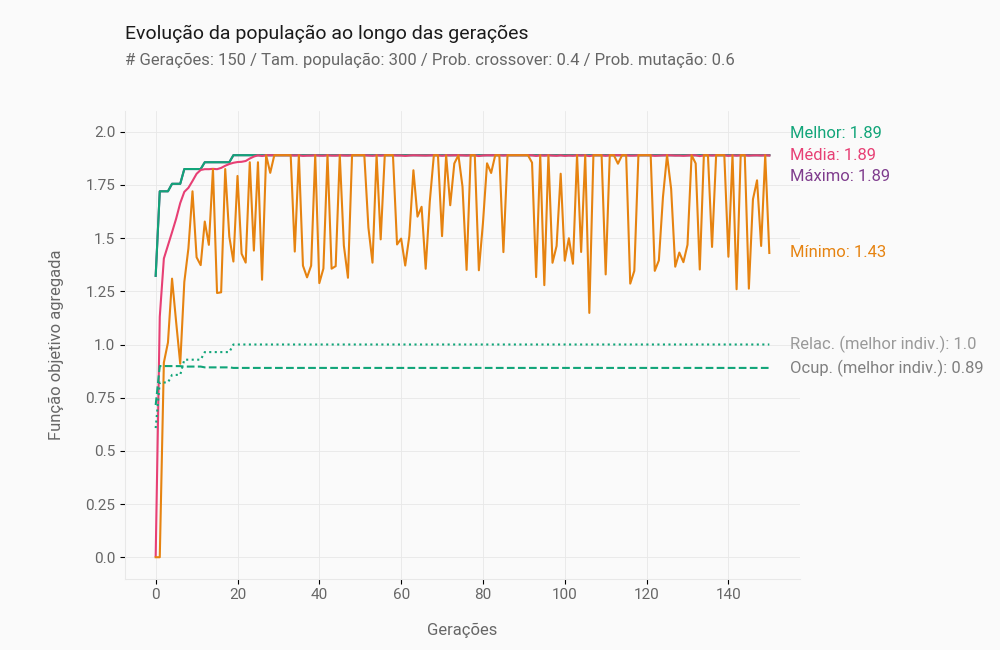

In [66]:
# Colors used to shade countries
COLOR_SCALE = [
"#7F3C8D", # MAX
"#11A579", # BEST
"#E73F74", # MEAN
"#E68310", # MIN
]

GREY10 = "#1a1a1a"
GREY40 = "#666666"
GREY50 = "#7f7f7f"
GREY60 = "#999999"
GREY91 = "#e8e8e8"
GREY98 = "#fafafa"

# Vertical / horizontal lines
HLINES = np.arange(0, N_GEN+1, 20)
VLINES = np.linspace(0.0, 2.0, 9)

# Initialize layout 
fig, ax = plt.subplots(figsize = (10, 6.5))

# Background color
fig.patch.set_facecolor(GREY98)
ax.set_facecolor(GREY98)

# Vertical / horizontal lines
for h in HLINES:
    ax.axvline(h, color=GREY91, lw=0.6, zorder=0)

# Vertical / horizontal lines
for h in VLINES:
    ax.axhline(h, color=GREY91, lw=0.6, zorder=0)

# Add lines 
ax.plot(epochs_max, color=COLOR_SCALE[0])
ax.plot(epochs_best, color=COLOR_SCALE[1])
ax.plot(epochs_avg, color=COLOR_SCALE[2])
ax.plot(epochs_min, color=COLOR_SCALE[3])
ax.plot(epochs_best_ocupacao, color=COLOR_SCALE[1], ls='--')
ax.plot(epochs_best_relacionamento, color=COLOR_SCALE[1], ls=':')

# Customize spines
ax.spines["left"].set_color(GREY91)
ax.spines["bottom"].set_color(GREY91)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Customize axes labels and ticks 
ax.set_yticks([y for y in VLINES])
ax.set_yticklabels(
    [y for y in VLINES], 
    fontname="Roboto", 
    fontsize=11,
    weight=500,
    color=GREY40
)

ax.set_xticks([x for x in HLINES])
ax.set_xticklabels(
    [x for x in HLINES], 
    fontname= "Roboto", 
    fontsize=11,
    weight=500,
    color=GREY40
)

# Add label
ax.text(N_GEN+5, epochs_max[-1]-.1, f'Máximo: {round(epochs_max[-1], 2)}', color=COLOR_SCALE[0], fontsize=12, weight="bold", fontfamily="Roboto", va="center")
ax.text(N_GEN+5, epochs_best[-1][0]+.1, f'Melhor: {round(epochs_best[-1][0], 2)}', color=COLOR_SCALE[1], fontsize=12, weight="bold", fontfamily="Roboto", va="center")
ax.text(N_GEN+5, epochs_avg[-1], f'Média: {round(epochs_avg[-1], 2)}', color=COLOR_SCALE[2], fontsize=12, weight="bold", fontfamily="Roboto", va="center")
ax.text(N_GEN+5, epochs_min[-1], f'Mínimo: {round(epochs_min[-1], 2)}', color=COLOR_SCALE[3], fontsize=12, weight="bold", fontfamily="Roboto", va="center")
ax.text(N_GEN+5, epochs_best_ocupacao[-1], f'Ocup. (melhor indiv.): {round(epochs_best_ocupacao[-1], 2)}', color=GREY50, fontsize=12, weight="bold", fontfamily="Roboto", va="center")
ax.text(N_GEN+5, epochs_best_relacionamento[-1], f'Relac. (melhor indiv.): {round(epochs_best_relacionamento[-1], 2)}', color=GREY60, fontsize=12, weight="bold", fontfamily="Roboto", va="center")

fig.text(0.125, 0.97, '', fontsize=14, fontweight='bold', fontname='Roboto', color=GREY10)
fig.text(0.125, 0.94, 'Evolução da população ao longo das gerações', fontsize=14, fontweight='bold', fontname='Roboto', color=GREY10)
fig.text(0.125, 0.90, f'# Gerações: {N_GEN} / Tam. população: {N_POP} / Prob. crossover: {CXPB} / Prob. mutação: {MUTPB}', fontsize=12, fontweight='bold', fontname='Roboto', color=GREY40)
ax.set_xlabel('Gerações', fontsize=12, fontweight='bold', fontname='Roboto', color=GREY40, labelpad=15)
ax.set_ylabel('Função objetivo agregada', fontsize=12, fontweight='bold', fontname='Roboto', color=GREY40, labelpad=15)

plt.subplots_adjust(top=0.83, right=0.8)

In [67]:
# Melhores soluções
print("Melhores Indivíduos:")

qtd_pessoas_com_total = df_pessoas_por_gerencia.copy()
qtd_pessoas_com_total.loc['Total'] = 'Total'

for ind in hof:
    melhor = pd.DataFrame(ind, columns=COLUNAS_DIAS)
    melhor.loc['Total'] = pd.Series(melhor.sum())
    resultado_completo = qtd_pessoas_com_total.join(melhor)[['Gerência'] + COLUNAS_DIAS]
    display(resultado_completo)
    print(funcao_de_restricao(ind))
    print(funcao_objetivo(ind))

Melhores Indivíduos:


,Gerência,Segunda,Terça,Quarta,Quinta,Sexta
0,A_Próprio,4,4,4,0,0
1,A_Terceirizado,0,0,0,0,0
2,B_Próprio,17,17,17,0,0
3,B_Terceirizado,1,1,0,0,0
4,C_Próprio,0,61,0,61,61
5,C_Terceirizado,0,0,0,13,13
6,D_Próprio,3,3,3,0,0
7,D_Terceirizado,0,0,0,0,0
8,E_Próprio,52,52,52,0,0
9,E_Terceirizado,8,8,0,0,0


True
(np.float64(0.889886108857842), 1.0)


,Gerência,Segunda,Terça,Quarta,Quinta,Sexta
0,A_Próprio,4,4,4,0,0
1,A_Terceirizado,0,0,0,0,0
2,B_Próprio,17,17,17,0,0
3,B_Terceirizado,1,1,0,0,0
4,C_Próprio,0,61,0,61,61
5,C_Terceirizado,0,0,0,13,13
6,D_Próprio,3,3,3,0,0
7,D_Terceirizado,0,0,0,0,0
8,E_Próprio,52,52,52,0,0
9,E_Terceirizado,8,8,0,0,0


True
(np.float64(0.8924910490444123), 0.9642857142857143)


,Gerência,Segunda,Terça,Quarta,Quinta,Sexta
0,A_Próprio,4,4,4,0,0
1,A_Terceirizado,0,0,0,0,0
2,B_Próprio,17,17,17,0,0
3,B_Terceirizado,1,0,0,1,0
4,C_Próprio,0,61,0,61,61
5,C_Terceirizado,0,0,0,13,13
6,D_Próprio,3,3,3,0,0
7,D_Terceirizado,0,0,0,0,0
8,E_Próprio,52,52,52,0,0
9,E_Terceirizado,8,8,0,0,0


True
(np.float64(0.8905990675556702), 0.9642857142857143)


,Gerência,Segunda,Terça,Quarta,Quinta,Sexta
0,A_Próprio,4,4,0,4,0
1,A_Terceirizado,0,0,0,0,0
2,B_Próprio,17,17,17,0,0
3,B_Terceirizado,1,1,0,0,0
4,C_Próprio,0,61,0,61,61
5,C_Terceirizado,0,0,0,13,13
6,D_Próprio,3,3,3,0,0
7,D_Terceirizado,0,0,0,0,0
8,E_Próprio,52,52,52,0,0
9,E_Terceirizado,8,8,0,0,0


True
(np.float64(0.890138196692867), 0.9642857142857143)


,Gerência,Segunda,Terça,Quarta,Quinta,Sexta
0,A_Próprio,4,4,4,0,0
1,A_Terceirizado,0,0,0,0,0
2,B_Próprio,17,0,17,17,0
3,B_Terceirizado,1,1,0,0,0
4,C_Próprio,0,61,0,61,61
5,C_Terceirizado,0,13,0,0,13
6,D_Próprio,3,3,3,0,0
7,D_Terceirizado,0,0,0,0,0
8,E_Próprio,52,52,52,0,0
9,E_Terceirizado,8,8,0,0,0


True
(np.float64(0.889886108857842), 0.9642857142857143)


### Configuração do deap (multi-objetivo)

In [68]:
creator.create("MultiFitness", base.Fitness, weights=(1.0, 1.0))
creator.create("MultiIndividual", list, fitness=creator.MultiFitness)

toolbox_multi = base.Toolbox()

# Inicialização do cromossomo (quantos genes o cromossomo deve possuir)
toolbox_multi.register("individual", gerador_individuo, creator.MultiIndividual)

# Registro do individuo na população
toolbox_multi.register("population", tools.initRepeat, list, toolbox_multi.individual)

# Registro do nome da função objetivo
toolbox_multi.register("evaluate", funcao_objetivo)

# Registro da função de penalidade caso o individuo não obedeça as restrições
toolbox_multi.decorate("evaluate", tools.DeltaPenalty(funcao_de_restricao, 0))

# Registro de qual o tipo de cruzamento deve ser utilizado (cruzamento de 2 pontos)
toolbox_multi.register("mate", crossover_two_point, creator.MultiIndividual)

# Registro de qual tipo de mutação deve ser utilizado (probabilidade de um individuo sofrer mutação)
toolbox_multi.register("mutate", mutacao, indpb=0.4)

# Registro de qual o tipo do método de seleção que será utilizado
toolbox_multi.register("select", tools.selNSGA2)
# toolbox_multi.register("select", tools.selNSGA3, ref_points=tools.uniform_reference_points(nobj=2, p=12))


C:\Users\U4DD\AppData\Roaming\Python\Python312\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'MultiFitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\U4DD\AppData\Roaming\Python\Python312\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'MultiIndividual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [69]:
pop_multi = toolbox_multi.population(n=N_POP)               # inicialização da pop
hof_pareto = tools.ParetoFront()                          # melhores indivíduos
stats_multi = tools.Statistics(lambda ind: ind.fitness.values)  # estatísticas
stats_multi.register("avg", np.mean, axis=0)
stats_multi.register("std", np.std, axis=0)
stats_multi.register("min", np.min, axis=0)
stats_multi.register("max", np.max, axis=0)
history_multi = tools.Statistics(lambda ind: ind)
history_multi.register('hof', lambda pop: hof_pareto[:])
history_multi.register('best', lambda pop: max(pop, key=lambda ind: sum(ind.fitness.values)))
mstats = tools.MultiStatistics(fitness=stats_multi, history=history_multi)

In [ ]:
# pop_multi, log_multi = algorithms.eaSimple(pop_multi, toolbox_multi, cxpb=CXPB, mutpb=MUTPB, ngen=N_GEN, stats=mstats, halloffame=hof_pareto, verbose=True)
pop_multi, log_multi = algorithms.eaMuPlusLambda(pop_multi, toolbox_multi, mu=N_POP, lambda_=N_POP, cxpb=CXPB, mutpb=MUTPB, ngen=N_GEN, stats=mstats, halloffame=hof_pareto, verbose=True)

   	      	                    fitness                    	                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [ ]:
multi_epochs_best = [[funcao_objetivo(ind) for ind in value] for epoch_kv in log_multi.chapters['history'] for key,value in epoch_kv.items() if key == 'hof']
multi_epochs_best_individual = [funcao_objetivo(value) for epoch_kv in log_multi.chapters['history'] for key,value in epoch_kv.items() if key == 'best']

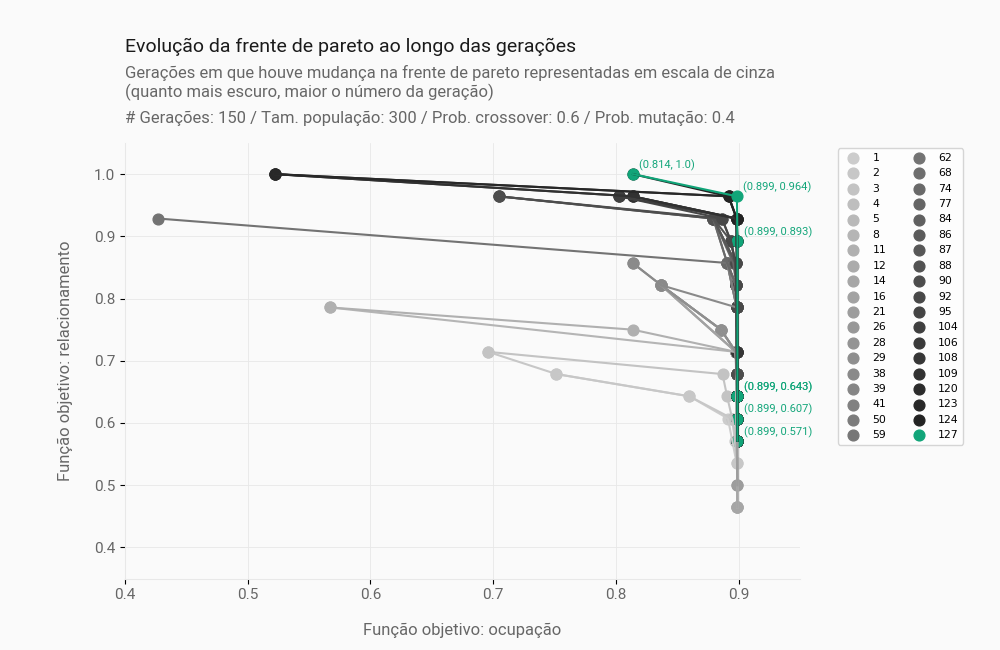

In [ ]:
# Vertical / horizontal lines
HLINES = np.around(np.linspace(0, 1.0, 11),2)
VLINES = np.around(np.linspace(0, 1.0, 11),2)

# Initialize layout 
fig, ax = plt.subplots(figsize = (10, 6.5))

# Background color
fig.patch.set_facecolor(GREY98)
ax.set_facecolor(GREY98)

# Vertical / horizontal lines
for h in HLINES:
    ax.axvline(h, color=GREY91, lw=0.6, zorder=0)

# Vertical / horizontal lines
for h in VLINES:
    ax.axhline(h, color=GREY91, lw=0.6, zorder=0)

# Scatter plot 
# for (gen, pareto) in enumerate(multi_epochs_best):
#     if gen == 0 or gen % 10 != 0: continue
#     x = []
#     y = []
#     for result in pareto:
#         x.append(result[0])
#         y.append(result[1])
#     color = (str(0.8 - gen/N_GEN*0.5), 0.2) if gen < N_GEN else COLOR_SCALE[1]
#     ax.scatter(x, y, c=color, s=60)

pareto_changes = {}
previous_pareto = []
for (gen, pareto) in enumerate(multi_epochs_best):
    if gen == 0: continue

    if np.shape(pareto) == np.shape(previous_pareto):
        if np.sum(np.subtract(pareto, previous_pareto)) == 0:
            continue
        
    x = []
    y = []
    for result in pareto:
        x.append(result[0])
        y.append(result[1])

    pareto_changes[gen] = (x, y)
    last_gen = gen
    previous_pareto = pareto

qtd_pareto_changes = len(pareto_changes.items())

for i, (gen, pareto) in enumerate(pareto_changes.items()):
    color = (str(0.8 - i/qtd_pareto_changes*0.7), 1) if i < qtd_pareto_changes - 1 else COLOR_SCALE[1]
    ax.scatter(pareto[0], pareto[1], c=color, s=60, label = gen)
    ax.plot(pareto[0], pareto[1], c=color)

for pareto in previous_pareto: # previous_pareto é o último do loop
    text = ax.text(pareto[0]+0.005, pareto[1]+0.005, f'({round(pareto[0], 3)}, {round(pareto[1], 3)})', 
                   fontsize=8, fontname='Roboto', color=COLOR_SCALE[1], ha='left', va='bottom', zorder=10)

# Customize spines
ax.spines["left"].set_color(GREY91)
ax.spines["bottom"].set_color(GREY91)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Customize axes labels and ticks 
ax.set_yticks([y for y in VLINES])
ax.set_yticklabels(
    [y for y in VLINES], 
    fontname="Roboto", 
    fontsize=11,
    weight=500,
    color=GREY40
)

ax.set_xticks([x for x in HLINES])
ax.set_xticklabels(
    [x for x in HLINES], 
    fontname= "Roboto", 
    fontsize=11,
    weight=500,
    color=GREY40
)

ax.set_xlabel('Função objetivo: ocupação', fontsize=12, fontweight='bold', fontname='Roboto', color=GREY40, labelpad=15)
ax.set_ylabel('Função objetivo: relacionamento', fontsize=12, fontweight='bold', fontname='Roboto', color=GREY40, labelpad=15)
ax.set_xlim((0.4, 0.95))
ax.set_ylim((0.35, 1.05))

fig.text(0.125, 0.94, '', fontsize=14, fontweight='bold', fontname='Roboto', color=GREY10)
fig.text(0.125, 0.92, 'Evolução da frente de pareto ao longo das gerações', fontsize=14, fontweight='bold', fontname='Roboto', color=GREY10)
fig.text(0.125, 0.85, 'Gerações em que houve mudança na frente de pareto representadas em escala de cinza\n(quanto mais escuro, maior o número da geração)', fontsize=12, fontweight='bold', fontname='Roboto', color=GREY40)
fig.text(0.125, 0.81, f'# Gerações: {N_GEN} / Tam. população: {N_POP} / Prob. crossover: {CXPB} / Prob. mutação: {MUTPB}', fontsize=12, fontweight='bold', fontname='Roboto', color=GREY40)

ax.legend(bbox_to_anchor=(1.25, 1), loc='upper right', fontsize=7.8, ncol=2)

plt.subplots_adjust(top=0.78, right=0.8)
plt.show()


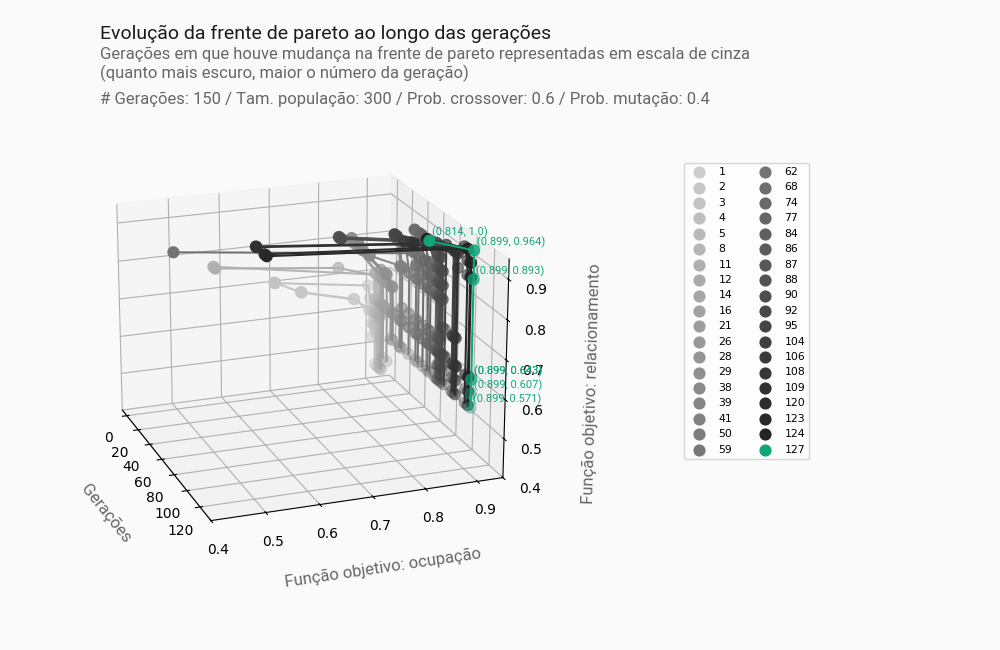

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig = plt.figure(figsize=(10,6.5))
ax = fig.add_subplot(111, projection='3d',computed_zorder=False)

# Background color
fig.patch.set_facecolor(GREY98)
ax.set_facecolor(GREY98)

# for (gen, pareto) in enumerate(multi_epochs_best):
#     if gen % 10 != 0: continue
#     y = []
#     z = []
#     for result in pareto:
#         y.append(result[0])
#         z.append(result[1])
#     color = (str(0.8 - gen/N_GEN*0.5), 0.2) if gen < N_GEN else COLOR_SCALE[1]
#     ax.scatter(gen, y, z, c=color, s=60)

pareto_changes = {}
previous_pareto = []
for (gen, pareto) in enumerate(multi_epochs_best):
    if gen == 0: continue

    if np.shape(pareto) == np.shape(previous_pareto):
        if np.sum(np.subtract(pareto, previous_pareto)) == 0:
            continue
        
    x = []
    y = []
    for result in pareto:
        x.append(result[0])
        y.append(result[1])

    pareto_changes[gen] = (x, y)
    last_gen = gen
    previous_pareto = pareto

qtd_pareto_changes = len(pareto_changes.items())

for i, (gen, pareto) in enumerate(pareto_changes.items()):
    color = (str(0.8 - i/qtd_pareto_changes*0.7), 1) if i < qtd_pareto_changes - 1 else COLOR_SCALE[1]
    ax.scatter(gen, pareto[0], pareto[1], c=color, s=60, label = gen, zorder=gen*10)
    ax.plot(gen, pareto[0], pareto[1], c=color, zorder=gen*10)

for pareto in previous_pareto: # previous_pareto é o último do loop
    text = ax.text(last_gen, pareto[0]+0.005, pareto[1]+0.005, f'({round(pareto[0], 3)}, {round(pareto[1], 3)})', 
                   fontsize=8, fontname='Roboto', fontweight='bold', color=COLOR_SCALE[1], ha='left', va='bottom', zorder=last_gen)

# plot
ax.view_init(20, 340)
ax.set_xlabel('Gerações', fontsize=12, fontweight='bold', fontname='Roboto', color=GREY40, labelpad=15)
ax.set_ylabel('Função objetivo: ocupação', fontsize=12, fontweight='bold', fontname='Roboto', color=GREY40, labelpad=15)
ax.set_zlabel('Função objetivo: relacionamento', fontsize=12, fontweight='bold', fontname='Roboto', color=GREY40, labelpad=15)

fig.text(0.1, 0.97, '', fontsize=14, fontweight='bold', fontname='Roboto', color=GREY10)
fig.text(0.1, 0.94, 'Evolução da frente de pareto ao longo das gerações', fontsize=14, fontweight='bold', fontname='Roboto', color=GREY10)
fig.text(0.1, 0.88, 'Gerações em que houve mudança na frente de pareto representadas em escala de cinza\n(quanto mais escuro, maior o número da geração)', fontsize=12, fontweight='bold', fontname='Roboto', color=GREY40)
fig.text(0.1, 0.84, f'# Gerações: {N_GEN} / Tam. população: {N_POP} / Prob. crossover: {CXPB} / Prob. mutação: {MUTPB}', fontsize=12, fontweight='bold', fontname='Roboto', color=GREY40)

ax.set_ylim((0.4, 0.95))
ax.set_zlim((0.4, 0.95))

ax.legend(bbox_to_anchor=(1.6, 0.9), loc='upper right', fontsize=7.8, ncol=2)

plt.subplots_adjust(top=0.83, left=-0.3)

plt.show()

In [ ]:
# Melhores soluções
print("Melhores Indivíduos:")

qtd_pessoas_com_total = df_pessoas_por_gerencia.copy()
qtd_pessoas_com_total.loc['Total'] = 'Total'

for ind in hof_pareto:
    melhor = pd.DataFrame(ind, columns=COLUNAS_DIAS)
    melhor.loc['Total'] = pd.Series(melhor.sum())
    resultado_completo = qtd_pessoas_com_total.join(melhor)[['Gerência'] + COLUNAS_DIAS]
    display(resultado_completo)
    print(funcao_de_restricao(ind))
    print(funcao_objetivo(ind))

Melhores Indivíduos:


,Gerência,Segunda,Terça,Quarta,Quinta,Sexta
0,A_Próprio,4,4,4,0,0
1,A_Terceirizado,0,0,0,0,0
2,B_Próprio,0,17,17,0,17
3,B_Terceirizado,0,0,0,1,1
4,C_Próprio,0,61,0,61,61
5,C_Terceirizado,0,0,0,13,13
6,D_Próprio,3,3,3,0,0
7,D_Terceirizado,0,0,0,0,0
8,E_Próprio,52,52,52,0,0
9,E_Terceirizado,8,0,0,8,0


True
(np.float64(0.8992353663300913), 0.6428571428571429)


,Gerência,Segunda,Terça,Quarta,Quinta,Sexta
0,A_Próprio,4,4,4,0,0
1,A_Terceirizado,0,0,0,0,0
2,B_Próprio,0,17,17,0,17
3,B_Terceirizado,0,0,0,1,1
4,C_Próprio,0,61,0,61,61
5,C_Terceirizado,0,13,0,0,13
6,D_Próprio,3,3,3,0,0
7,D_Terceirizado,0,0,0,0,0
8,E_Próprio,52,52,52,0,0
9,E_Terceirizado,8,0,0,8,0


True
(np.float64(0.8992353663300913), 0.6428571428571429)


,Gerência,Segunda,Terça,Quarta,Quinta,Sexta
0,A_Próprio,4,4,4,0,0
1,A_Terceirizado,0,0,0,0,0
2,B_Próprio,17,17,17,0,0
3,B_Terceirizado,0,1,0,0,1
4,C_Próprio,0,61,0,61,61
5,C_Terceirizado,13,13,0,0,0
6,D_Próprio,0,0,3,3,3
7,D_Terceirizado,0,0,0,0,0
8,E_Próprio,52,52,52,0,0
9,E_Terceirizado,8,8,0,0,0


True
(np.float64(0.899005814863723), 0.75)


,Gerência,Segunda,Terça,Quarta,Quinta,Sexta
0,A_Próprio,4,4,4,0,0
1,A_Terceirizado,0,0,0,0,0
2,B_Próprio,0,0,17,17,17
3,B_Terceirizado,0,1,0,0,1
4,C_Próprio,61,61,0,61,0
5,C_Terceirizado,13,0,0,13,0
6,D_Próprio,0,3,0,3,3
7,D_Terceirizado,0,0,0,0,0
8,E_Próprio,52,52,52,0,0
9,E_Terceirizado,8,8,0,0,0


True
(np.float64(0.8987710796214967), 0.8214285714285714)


,Gerência,Segunda,Terça,Quarta,Quinta,Sexta
0,A_Próprio,4,4,4,0,0
1,A_Terceirizado,0,0,0,0,0
2,B_Próprio,0,17,0,17,17
3,B_Terceirizado,1,1,0,0,0
4,C_Próprio,0,0,61,61,61
5,C_Terceirizado,0,0,0,13,13
6,D_Próprio,3,3,3,0,0
7,D_Terceirizado,0,0,0,0,0
8,E_Próprio,52,52,52,0,0
9,E_Terceirizado,8,8,0,0,0


True
(np.float64(0.8985598285111256), 0.8928571428571429)


,Gerência,Segunda,Terça,Quarta,Quinta,Sexta
0,A_Próprio,4,4,4,0,0
1,A_Terceirizado,0,0,0,0,0
2,B_Próprio,0,17,0,17,17
3,B_Terceirizado,0,1,0,0,1
4,C_Próprio,0,0,61,61,61
5,C_Terceirizado,0,0,0,13,13
6,D_Próprio,3,3,3,0,0
7,D_Terceirizado,0,0,0,0,0
8,E_Próprio,52,52,52,0,0
9,E_Terceirizado,8,8,0,0,0


True
(np.float64(0.8985598285111256), 0.8928571428571429)


,Gerência,Segunda,Terça,Quarta,Quinta,Sexta
0,A_Próprio,4,4,4,0,0
1,A_Terceirizado,0,0,0,0,0
2,B_Próprio,0,17,0,17,17
3,B_Terceirizado,0,1,0,0,1
4,C_Próprio,0,0,61,61,61
5,C_Terceirizado,0,0,0,13,13
6,D_Próprio,3,3,3,0,0
7,D_Terceirizado,0,0,0,0,0
8,E_Próprio,52,52,52,0,0
9,E_Terceirizado,8,8,0,0,0


True
(np.float64(0.8983296399987815), 0.9285714285714286)


,Gerência,Segunda,Terça,Quarta,Quinta,Sexta
0,A_Próprio,4,4,4,0,0
1,A_Terceirizado,0,0,0,0,0
2,B_Próprio,0,17,0,17,17
3,B_Terceirizado,0,0,0,1,1
4,C_Próprio,0,0,61,61,61
5,C_Terceirizado,0,0,0,13,13
6,D_Próprio,3,3,3,0,0
7,D_Terceirizado,0,0,0,0,0
8,E_Próprio,52,52,52,0,0
9,E_Terceirizado,8,8,0,0,0


True
(np.float64(0.8917972729045732), 0.9642857142857143)


,Gerência,Segunda,Terça,Quarta,Quinta,Sexta
0,A_Próprio,4,4,4,0,0
1,A_Terceirizado,0,0,0,0,0
2,B_Próprio,0,17,0,17,17
3,B_Terceirizado,0,0,0,1,1
4,C_Próprio,0,0,61,61,61
5,C_Terceirizado,0,0,0,13,13
6,D_Próprio,3,3,3,0,0
7,D_Terceirizado,0,0,0,0,0
8,E_Próprio,52,52,52,0,0
9,E_Terceirizado,8,8,0,0,0


True
(np.float64(0.8824242916594768), 1.0)
